<a href="https://colab.research.google.com/github/Phosics/ReinforcementLearningFinal/blob/main/FinalAssignmentItzikTesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mid Semester Project - DEEP Reinforcements Learning
Dear students,<br> this is the template notebook. Please copy it by clicking on the "File" tab and then on "Save a copy into drive".

---
<br>

### Name and ID:
Student 1:
<br>
Student 2:
<br><br>
<img src="https://raw.githubusercontent.com/Farama-Foundation/Minigrid/master/minigrid-text.png">

### https://minigrid.farama.org/

# Pre-Requisit

## Installs

In [1]:
%%capture
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install gymnasium
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install -U --no-cache-dir gdown --pre
!pip install minigrid
!wget -q https://www.dropbox.com/scl/fi/jhkb2y3jw8wgin9e26ooc/MiniGrid-MultiRoom-N6-v0_vid.mp4?rlkey=qtkrmmbk9aiote5z7w4bx6ixi&st=zbr4gk21&dl=1 -O content/MiniGrid-MultiRoom-N6-v0_vid.mp4


## Imports

In [2]:
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pyvirtualdisplay
import IPython
import base64
import gymnasium
import minigrid
from minigrid.wrappers import RGBImgObsWrapper, RGBImgPartialObsWrapper, ImgObsWrapper, FullyObsWrapper, RGBImgPartialObsWrapper
from gymnasium.wrappers import FrameStackObservation
import matplotlib.pyplot as plt
import imageio
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

In [3]:
# Constants for the environemnt configuration do no change the values
highlight = False
render_mode = "rgb_array"

## Display utils
The cell below contains the video display configuration. No need to make changes here.

In [4]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

# Introduction

For this project, you will work with environments from the [MiniGrid](https://minigrid.farama.org) framework. MiniGrid is designed to test and benchmark reinforcement learning algorithms, offering a diverse range of tasks with varying levels of complexity.

MiniGrid environments are built around the concept of a partially observable, grid-based world where an agent operates to achieve predefined objectives.

## **MultiRoom Environment**

You will work with the **MultiRoom Environment** see docomentation [here](https://minigrid.farama.org/environments/minigrid/MultiRoomEnv/). MultiRoomEnv introduces a level of complexity beyond simple navigation tasks by requiring the agent to navigate through multiple connected rooms to reach a goal. This environment is an excellent testbed for reinforcement learning algorithms that require exploration, memory, and planning.



## Understanding the `done` and `truncated` Mechanisms in MultiRoomEnv

As you experienced in the MidTerm assignment, the **GYM** API returns multiple outputs from the **`step`** method. In the MultiRoomEnv environment, two key mechanisms, **`done`** and **`truncated`**, are used to signify the end of an episode. These mechanisms are essential for managing the flow of training and providing valuable feedback about the agent's performance.


### `done`
- The `done` flag is set to `True` when the agent successfully reaches the goal.
- It indicates the successful termination of the episode, meaning the agent has completed the task.
- Example scenario: The agent navigates through all the rooms and reaches the green goal square in the final room.

### `truncated`
- The `truncated` flag is used to terminate an episode when a predefined condition is met, such as exceeding the maximum number of steps allowed.
- It does not necessarily indicate success or failure, but rather ensures that episodes do not run indefinitely.
- Example scenario: The agent fails to reach the goal within the allowed number of steps, and the episode ends prematurely.

**Pay Attention!**

Each time the environment is reset, the configuration of the rooms is randomized. This variability should be carefully considered during training, as resetting the environment every time the `max_step` limit is reached can make it challenging for the agent to learn effectively.

Additionally, note that the `max_step` parameter is defined as the number of rooms multiplied by 20.


## Random Action Rendering

In [5]:
env = gymnasium.make("MiniGrid-MultiRoom-N6-v0", render_mode=render_mode, highlight=highlight)
video_filename = '/content/vid.mp4'
truncated = False
# Evaluation
with imageio.get_writer(video_filename, fps=16) as video:
  obs, _ = env.reset()
  done = False
  total_reward = 0
  step = 0
  while not truncated:
      action = env.action_space.sample()
      obs, reward, done, truncated  , _ = env.step(action)
      next_obs = obs  # Get agent's position directly from the environment
      video.append_data(env.render())
      step += 1
      if truncated:
        print("done","reward=", total_reward,"num_of_steps=",step)
        break
embed_mp4(video_filename)

done reward= 0 num_of_steps= 120


## Wrappers for Observations: ImgObsWrapper and RGBImgPartialObsWrapper

For this project, you will use two wrappers provided by MiniGrid: **ImgObsWrapper** and **RGBImgPartialObsWrapper**. These wrappers modify the agent's observations.

### ImgObsWrapper
- The **ImgObsWrapper** converts the observation from its default dictionary format into a single image array.
- By default, observations in MiniGrid are returned as a dictionary containing both image data and other optional keys (e.g., mission strings). This wrapper extracts only the image component for simplicity.

### RGBImgPartialObsWrapper
- This wrapper provides a **partial view of the environment**, but instead of limiting it to a fixed field of view, it shows the **entire visible content of the current room** from the agent's position to the walls in the direction the agent is facing.
- The observation dynamically updates as the agent moves or turns, allowing it to see the layout of the room but not beyond its walls or through closed doors.
- This introduces the challenge of **partial observability across multiple rooms**, as the agent must explore and navigate to new rooms to gather more information about the environment.





### Wrapper Usage
To apply a wrapper, you can modify your environment setup as follows:

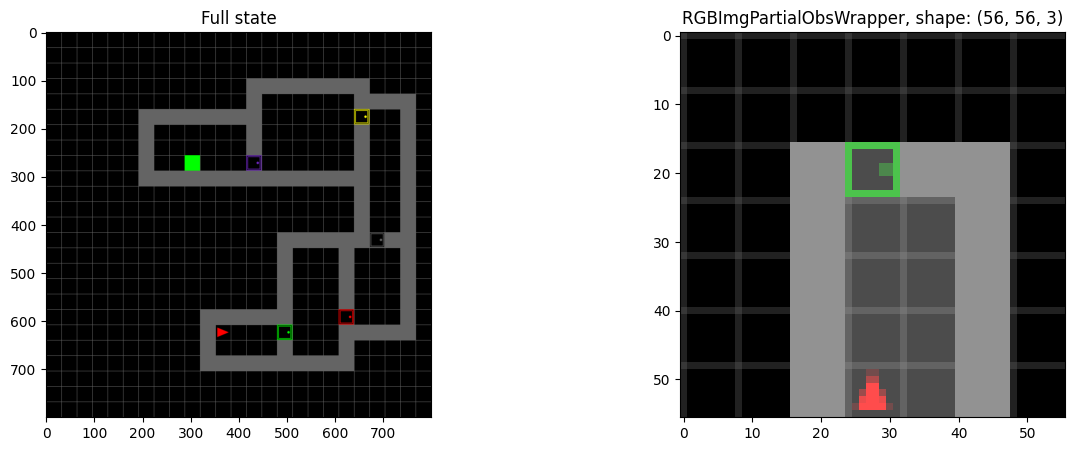

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
env = gymnasium.make("MiniGrid-MultiRoom-N6-v0", render_mode=render_mode, highlight=highlight)
env = RGBImgPartialObsWrapper(env)
env = ImgObsWrapper(env)
obs, _ = env.reset()
axs[1].imshow(obs)
axs[1].title.set_text(f'RGBImgPartialObsWrapper, shape: {obs.shape}')
axs[0].imshow(env.render())
axs[0].title.set_text(f'Full state')
plt.show()

## Initializing the smaller environments

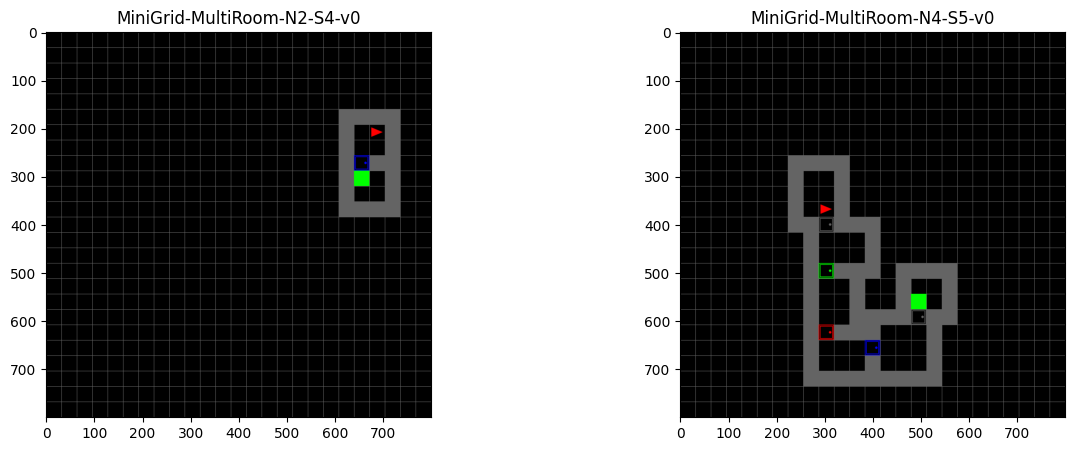

In [7]:
env = gymnasium.make("MiniGrid-MultiRoom-N2-S4-v0", render_mode=render_mode, highlight=highlight)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
env = RGBImgPartialObsWrapper(env)
env = ImgObsWrapper(env)
obs, _ = env.reset()
axs[0].imshow(env.render())
axs[0].title.set_text(f'MiniGrid-MultiRoom-N2-S4-v0')



env = gymnasium.make("MiniGrid-MultiRoom-N4-S5-v0", render_mode=render_mode, highlight=highlight)
env = RGBImgPartialObsWrapper(env)
env = ImgObsWrapper(env)
obs, _ = env.reset()
axs[1].imshow(env.render())
axs[1].title.set_text(f'MiniGrid-MultiRoom-N4-S5-v0')
plt.show()

### Partial Observation Example

In [8]:
env = gymnasium.make("MiniGrid-MultiRoom-N6-v0", render_mode=render_mode, highlight=highlight)
env = RGBImgPartialObsWrapper(env)
env = ImgObsWrapper(env)
video_filename = '/content/vid_partial.mp4'
truncated = False
# Evaluation
with imageio.get_writer(video_filename, fps=10) as video:
  obs, _ = env.reset()
  done = False
  total_reward = 0
  step = 0
  while not truncated:
      action = env.action_space.sample()
      obs, reward, done, truncated  , _ = env.step(action)
      next_obs = obs  # Get agent's position directly from the environment
      video.append_data(obs)
      step += 1
      if truncated:
        print("done","reward=", total_reward,"num_of_steps=",step)
        break
embed_mp4(video_filename)

done reward= 0 num_of_steps= 120


## Exmple from our solution

In [9]:
# Step 1: Correct download path
# Call the function
embed_mp4('MiniGrid-MultiRoom-N6-v0_vid.mp4?rlkey=qtkrmmbk9aiote5z7w4bx6ixi')


In [10]:
# Set to use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
##############################################
# Reset Environment
##############################################
def env_reset(env, seed=None):
  if seed:
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    return env.reset(seed=seed)
  else:
    return env.reset()

##############################################
# Preprocess
##############################################
def preprocess_state(state):
    """
    Preprocess the state (image) from a gym environment.
    If the state is a single frame with shape (H, W, C), it returns a float tensor
    with shape (C, H, W) normalized to [0,1].
    If the state is a stack of frames with shape (num_stack, H, W, C),
    it processes each frame individually, resulting in a tensor with shape (num_stack, C, H, W).
    """
    state = np.array(state).astype(np.float32) / 255.0

    if state.ndim == 3:  # Single frame: (H, W, C)
        return np.transpose(state, (2, 0, 1))
    elif state.ndim == 4:  # Stacked frames: (num_stack, H, W, C)
        # Process each frame and stack along a new axis (resulting in shape: (num_stack, C, H, W))
        return np.stack([np.transpose(frame, (2, 0, 1)) for frame in state], axis=0)
    else:
        raise ValueError(f"Unexpected state shape: {state.shape}")

##############################################
# Epsilon Greedy Exploration Schedule
##############################################
def epsilon_by_frame(frame_idx):
  """
  Returns the epsilon value for the epsilon-greedy exploration strategy,
  decaying exponentially from EPSILON_START to EPSILON_FINAL.
  """
  return EPSILON_FINAL + (EPSILON_START - EPSILON_FINAL) * np.exp(-1. * frame_idx / EPSILON_DECAY)

##############################################
# Select Action
##############################################
def select_action(env, frame_idx, q_network, state_tensor):
  # Epsilon-greedy action selection.
  epsilon = epsilon_by_frame(frame_idx)

  if random.random() < epsilon:
    return env.action_space.sample()
  else:
    with torch.no_grad():
      q_vals = q_network.forward(state_tensor)
      return q_vals.argmax(1).item()

##############################################
# Custom Reward
##############################################
DOOR_OPEN_REWARD = 0.4
DOOR_CLOSE_PENALTY = -0.5     # Negative reward for closing an open door
STEP_PENALTY = -0.01
INVALID_TOGGLE_PENALTY = -0.2
DOOR_VIEW_REWARD = 0.05      # Reward for seeing a door in the field-of-view

# Constant for door type in the observation encoding.
# (Assumes that the door is encoded as the integer 3 in the observation's first channel.)
DOOR_TYPE = 3

def custom_reward(env, action, reward, done, truncated):
  env = env.unwrapped
  total_reward = STEP_PENALTY

  # Check for goal achievement.
  if done:
    return reward

  # --- Action-specific logic ---
  if action == env.actions.toggle:
    # Compute the coordinates of the cell in front of the agent.
    dx, dy = 0, 0
    if env.agent_dir == 0:
      dx = 1
    elif env.agent_dir == 1:
      dy = 1
    elif env.agent_dir == 2:
      dx = -1
    elif env.agent_dir == 3:
      dy = -1

    front_x = env.agent_pos[0] + dx
    front_y = env.agent_pos[1] + dy
    front_cell = env.grid.get(front_x, front_y)

    # Check if the front cell is a door.
    if front_cell is not None and getattr(front_cell, "type", None) == "door":
      if front_cell.is_open:
        total_reward += DOOR_OPEN_REWARD
      else:
        total_reward += DOOR_CLOSE_PENALTY
    else:
      total_reward += INVALID_TOGGLE_PENALTY
  else:
    # For non-toggle actions, check the entire field-of-view.
    # Generate the agent's observation. The 'image' key holds the egocentric view.
    obs = env.gen_obs()['image']
    door_seen = False
    # Iterate over each cell in the agent's view.
    for row in obs:
      for cell in row:
        # Each cell is encoded as [object_type, color, state].
        # We assume that a door is represented with object_type equal to DOOR_TYPE.
        if cell[0] == DOOR_TYPE:
          door_seen = True
          break
      if door_seen:
        break

    if door_seen:
      total_reward += DOOR_VIEW_REWARD

  return total_reward

# DQN

In [12]:
from IPython.display import display

##############################################
# Define the Q-Network (using PyTorch)
##############################################
class DuelingDQN(nn.Module):
  def __init__(self, input_shape, num_actions):
    """
    A dueling convolutional neural network that maps image observations to Q-values.
    """
    super(DuelingDQN, self).__init__()

    # input_shape: (num_stack, C, H, W)
    num_stacks, C, H, W = input_shape

    # Define a convolutional backbone for processing a single frame.
    self.conv = nn.Sequential(
        nn.Conv2d(C, 32, kernel_size=3, stride=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, stride=1),
        nn.ReLU(),
        nn.Flatten()
    )

    # Determine the size of the conv output for a single frame.
    with torch.no_grad():
        dummy_input = torch.zeros(1, C, H, W)
        conv_out_size = self.conv(dummy_input).shape[1]

    # A fully connected layer for further processing per frame.
    self.fc = nn.Sequential(
        nn.Linear(conv_out_size, 128),
        nn.ReLU()
    )

    # Value Stream
    self.value_stream = nn.Sequential(
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, 1)  # Outputs a single state-value estimate
    )

    # Advantage Stream
    self.advantage_stream = nn.Sequential(
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, num_actions)  # Outputs advantage estimates for each action
    )

  def forward(self, x):
    """
    x: input tensor of shape (batch_size, num_stack, C, H, W)
    """
    batch_size, num_stack, C, H, W = x.shape

    # Process each frame individually:
    # Reshape to (batch_size * num_stack, C, H, W)
    x = x.view(batch_size * num_stack, C, H, W).float() / 255.0

    conv_out = self.conv(x)  # -> (batch_size * num_stack, conv_out_size)
    fc_out = self.fc(conv_out)  # -> (batch_size * num_stack, 128)

    # Reshape back to (batch_size, num_stack, 128)
    fc_out = fc_out.view(batch_size, num_stack, -1)

    # Aggregate features across the time (frame stack) dimension.
    # Here we use mean aggregation, but you might also experiment with max or even an LSTM.
    aggregated = fc_out.mean(dim=1)  # -> (batch_size, 128)

    # Dueling streams:
    value = self.value_stream(aggregated)  # -> (batch_size, 1)
    advantage = self.advantage_stream(aggregated)  # -> (batch_size, num_actions)

    # Combine streams to compute Q-values.
    q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))
    return q_values

##############################################
# Experience Replay Buffer
##############################################
class ReplayBuffer:
  def __init__(self, capacity):
    self.capacity = capacity
    self.buffer = deque(maxlen=capacity)

  def push(self, state, action, reward, next_state, done):
    """
    Save a transition.
    """
    self.buffer.append((state, action, reward, next_state, done))

  def sample(self, batch_size):
    """
    Sample a batch of transitions.
    """
    batch = random.sample(self.buffer, batch_size)
    # Transpose the batch (list of tuples) into tuples of lists.
    states, actions, rewards, next_states, dones = zip(*batch)

    return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)

  def __len__(self):
    return len(self.buffer)

##############################################
# Plot Results
##############################################
def plot_result(log_every, rooms, episode_rewards, episode_steps, episode_finished):
  # Plot rewards and score
  fig, axs = plt.subplots(3, 1, figsize=(8, 6))

  # Generate X-axis values (e.g., for every 100 episodes)
  episodes = np.arange(log_every, log_every + len(episode_rewards) * log_every, log_every)

  # Plot rewards
  axs[0].plot(episodes, episode_rewards, label='Average Rewards')
  axs[0].set_xlabel('Episodes')
  axs[0].set_ylabel('Average Reward')
  axs[0].set_title('Average Rewards Over Time')
  axs[0].legend()

  #Plot scores
  axs[1].plot(episodes, episode_steps, label='Average Steps', color='orange')
  axs[1].set_xlabel('Steps')
  axs[1].set_ylabel('Average Steps')
  axs[1].set_title('Steps Over Time')
  axs[1].legend()

  #Plot episode lengths
  axs[2].plot(episodes, episode_finished, label='Amount of Episodes Finished', color='pink')
  axs[2].set_xlabel('Episodes')
  axs[2].set_ylabel('Amount of Episodes Finished')
  axs[2].set_title('Amount of Episodes Finished Over Time')
  axs[2].legend()

  plt.tight_layout()
  plt.show()

In [19]:
##############################################
# Main Training Loop
##############################################

def train(env, q_network, target_network, optimizer, seed=None):
  replay_buffer = ReplayBuffer(REPLAY_BUFFER_CAPACITY)

  episode_rewards = []
  episode_steps = []
  episode_finished = []

  frame_idx = 0
  losses = []
  finish_counter = 0
  best_avg_reward = -100

  for episode in range(1, NUM_EPISODES + 1):
    state, _ = env_reset(env)
    state = preprocess_state(state)
    episode_reward = 0
    done = False
    steps = 0

    while not done:
      frame_idx += 1
      # Prepare the current state tensor.
      state_tensor = torch.from_numpy(state).to(device)
      state_tensor = state_tensor.unsqueeze(0)

      # Epsilon-greedy action selection.
      action = select_action(env, frame_idx, q_network, state_tensor)

      # Take the action in the environment.
      next_state, reward, done, truncated, _ = env.step(action)
      custom_reward = custom_reward(env, action, reward, done, truncated)
      episode_reward += custom_reward
      next_state_proc = preprocess_state(next_state)

      # Save the transition in the replay buffer.
      replay_buffer.push(state, action, custom_reward, next_state_proc, done)
      state = next_state_proc

      # Update the Q-network once enough samples are available.
      if len(replay_buffer) > BATCH_SIZE:
        states, actions, rewards, next_states, dones = replay_buffer.sample(BATCH_SIZE)

        # Convert the mini-batch to PyTorch tensors.
        states = torch.tensor(states, dtype=torch.uint8).to(device)
        actions = torch.tensor(actions, dtype=torch.long).to(device)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        next_states = torch.tensor(next_states, dtype=torch.uint8).to(device)
        dones = torch.tensor(dones, dtype=torch.float32).to(device)

        # Compute Q-values for current states.
        q_values = q_network.forward(states)
        q_value = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

        # Compute target Q-values using the target network.
        with torch.no_grad():
          next_q_values = target_network(next_states)
          next_q_value = next_q_values.max(1)[0]
          target = rewards + GAMMA * next_q_value * (1 - dones)

        # Compute the loss (Mean Squared Error).
        loss = nn.MSELoss()(q_value, target)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the target network periodically.
        if frame_idx % TARGET_UPDATE_FREQ == 0:
          target_network.load_state_dict(q_network.state_dict())

        steps += 1

    if done and not truncated:
      finish_counter += 1

    episode_rewards.append(episode_reward)
    episode_steps.append(env.unwrapped.step_count)
    episode_finished.append(finish_counter)

    if episode % LOG_EVERY == 0:
      avg_reward = np.mean(episode_rewards[-10:])
      avg_steps = np.mean(episode_steps[-10:])
      avg_loss = np.mean(losses[-100:]) if losses else 0
      epsilon_val = epsilon_by_frame(frame_idx)

      if avg_reward > best_avg_reward:
        best_avg_reward = avg_reward
        print("Saving parameters...")
        torch.save(q_network.state_dict(), '/content/drive/MyDrive/RL/best_model.pth')

      print(f"Episode: {episode}, Frame: {frame_idx}, Epsilon: {epsilon_val}, Avg Reward (last 10): {avg_reward:.2f}, Loss: {avg_loss:.4f}, Avg Steps (last 10): {avg_steps:.2f}, Finished: {finish_counter}")

  env.close()

  return episode_rewards, episode_steps, episode_finished

In [20]:
##############################################
# Hyperparameters
##############################################

# Environment settings
ENV_NAME_2 = "MiniGrid-MultiRoom-N2-S4-v0"
ENV_NAME_4 = "MiniGrid-MultiRoom-N4-S5-v0"
ENV_NAME_6 = "MiniGrid-MultiRoom-N6-v0"
REPLAY_BUFFER_CAPACITY = 10000
BATCH_SIZE = 32
GAMMA = 0.99
LEARNING_RATE = 0.001
NUM_EPISODES = 700
TARGET_UPDATE_FREQ = 500  # steps
EPSILON_START = 1.0
EPSILON_FINAL = 0.1
EPSILON_DECAY = 500000  # steps over which epsilon decays
LOG_EVERY = 10

# Create the environment
env = gymnasium.make(ENV_NAME_2, render_mode=render_mode, highlight=highlight)

# Wrap to get a partial (RGB) observation and then extract the image
env = RGBImgPartialObsWrapper(env)
env = ImgObsWrapper(env)
env = FrameStackObservation(env, stack_size=3)

# Reset the environment
state, _ = env_reset(env)
state = preprocess_state(state)

# Get initial observation and derive input dimensions.
input_shape = state.shape
num_actions = env.action_space.n

# Initialize the Q-network and target network.
q_network = DuelingDQN(input_shape, num_actions).to(device)
target_network = DuelingDQN(input_shape, num_actions).to(device)
target_network.load_state_dict(q_network.state_dict())
target_network.eval()  # Target network is only used for inference.

optimizer = optim.Adam(q_network.parameters(), lr=LEARNING_RATE)

episode_rewards, episode_steps, episode_finished = train(env, q_network, target_network, optimizer)

plot_result(LOG_EVERY, 2, episode_rewards, episode_steps, episode_finished)

Saving parameters...
Episode: 10, Frame: 4800, Epsilon: 0.9914013396074944, Avg Reward (last 10): -9.80, Loss: 0.1897, Avg Steps (last 10): 480.00, Finished: 0
Saving parameters...
Episode: 20, Frame: 8999, Epsilon: 0.9839466970140968, Avg Reward (last 10): -8.45, Loss: 0.1060, Avg Steps (last 10): 419.90, Finished: 0
Episode: 30, Frame: 16768, Epsilon: 0.9703180880931184, Avg Reward (last 10): -16.48, Loss: 0.7490, Avg Steps (last 10): 776.90, Finished: 0
Episode: 40, Frame: 27077, Epsilon: 0.9525575918723231, Avg Reward (last 10): -22.20, Loss: 1.1035, Avg Steps (last 10): 1030.90, Finished: 0
Saving parameters...
Episode: 50, Frame: 30433, Epsilon: 0.9468543866835053, Avg Reward (last 10): -6.55, Loss: 0.0689, Avg Steps (last 10): 335.60, Finished: 0
Episode: 60, Frame: 36890, Epsilon: 0.9359884216804919, Avg Reward (last 10): -13.53, Loss: 0.6462, Avg Steps (last 10): 645.70, Finished: 0
Episode: 70, Frame: 42482, Epsilon: 0.926690816295009, Avg Reward (last 10): -11.58, Loss: 0.58

KeyboardInterrupt: 

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
NUM_EPISODES = 50

# Create the environment
env = gymnasium.make(ENV_NAME_4, render_mode=render_mode, highlight=highlight)

# Wrap to get a partial (RGB) observation and then extract the image
env = RGBImgPartialObsWrapper(env)
env = ImgObsWrapper(env)
env = FrameStackObservation(env, stack_size=3)

episode_rewards, episode_steps, episode_finished = train(env, q_network, target_network, optimizer)

plot_result(LOG_EVERY, 2, episode_rewards, episode_steps, episode_finished)

In [ ]:
NUM_EPISODES = 20

# Create the environment
env = gymnasium.make(ENV_NAME_6, render_mode=render_mode, highlight=highlight)

# Wrap to get a partial (RGB) observation and then extract the image
env = RGBImgPartialObsWrapper(env)
env = ImgObsWrapper(env)
env = FrameStackObservation(env, stack_size=3)

episode_rewards, episode_steps, episode_finished = train(env, q_network, target_network, optimizer)

plot_result(LOG_EVERY, 2, episode_rewards, episode_steps, episode_finished)